# SDDP and newsvendor

## Q-learning SDDP 

In [26]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-09-10


Gurobi.Env(Ptr{Nothing} @0x0000000005c34be0, false, 0)

In [27]:
function piecewise_linear(x,cuts)
    
    return maximum([cut[1]+cut[2]'*x for cut in cuts])
end

piecewise_linear (generic function with 1 method)

In [28]:
p = 1.0 #day ahead price
q = 2.0 #same day price

#condicion inicial de stock
x0=0.0;

In [29]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#@showprogress for i=1:50
for i=1:20
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x=value(stock)+value(reserve);

#demand=rand(DiscreteUniform(0,100));
    #resuelvo para todos los ruidos el segundo paso y agrego un corte
    local_cuts = [];

    for demand=(1:100)
        

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,shortage>=0);
        @variable(model,stock>=0);

        fix_x = @constraint(model,x-demand+shortage>=0);

#        fix_x = @constraint(model,stock==x);

        @objective(model,Min,q*shortage);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual(fix_x)

        push!(local_cuts,[beta-lambda*x;lambda])

    end

    new_cut = 1/length(local_cuts)*[sum([c[1] for c in local_cuts]);sum([c[2] for c in local_cuts])];
    push!(cuts,new_cut);
end

### Animación de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp.gif
└ @ Plots /home/andres/.julia/packages/Plots/ldLtW/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp.gif")
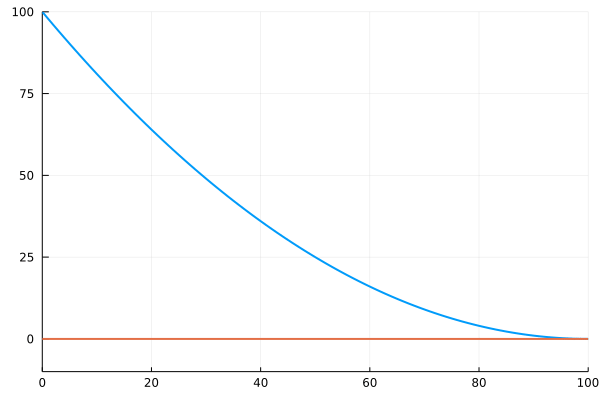

In [30]:
#Ploteo los cuts obtenidos
x=(0:100)

anim=nothing
anim = @animate for i=1:length(cuts)
    pl=plot(;legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,(100 .-x).^2/100,lw=2)

#    cut=cuts[i]
#    plot!(pl,cut[1].+cut[2]*x);
    plot!(pl,x,piecewise_linear.(x,Ref(cuts[1:i])),lw=2)

end

gif(anim,"tmp.gif",fps=1)